<a href="https://colab.research.google.com/github/yehezkielgunawan/thesis-risk-classification/blob/main/RF_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install scikit-learn
!pip install scikit-plot

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


# Load the new dataset for sentiment classification
new_data = pd.read_excel('/content/gdrive/My Drive/Tesis/Compiled Classification Dataset.xlsx')
sentences = new_data['content'].tolist()

# Load the exported word embeddings
embeddings = np.load('/content/gdrive/My Drive/Tesis/bert_embeddings.npy')

In [4]:
new_data.head(5)

,Unnamed: 0,content,priority_score,problem_domain
0,1,"Sorry, including the expensive price + apk usi...",2,0
1,2,Setelah install terus pas buka aplikasi ngebla...,3,1
2,3,"gak bisa submit pada saat verifikasi data, pad...",3,1
3,4,Aplilasi restart mulu,3,0
4,5,"udah mahal , makanan ga enak, banyak lalat",2,1


In [5]:
# Check the label distributions
priority_score_distribution = new_data['priority_score'].value_counts()
problem_domain_distribution = new_data['problem_domain'].value_counts()

print("Label priority_score Distribution:")
print(priority_score_distribution)

print("Label problem_domain Distribution:")
print(problem_domain_distribution)

Label priority_score Distribution:
3    277
2    275
1    148
Name: priority_score, dtype: int64
Label problem_domain Distribution:
0    570
1    130
Name: problem_domain, dtype: int64


In [6]:
# Check if the DataFrame contains any NaN values
rows_with_null = new_data[new_data.isnull().any(axis=1)]
rows_with_null

,Unnamed: 0,content,priority_score,problem_domain


In [13]:
# Assuming the labels for the new dataset are stored in two columns: 'label1' and 'label2'
priority_score = new_data['priority_score'][:len(embeddings)]
problem_domain = new_data['problem_domain'][:len(embeddings)]

# Truncate the embeddings to match the number of rows in new_data
embeddings = embeddings[:len(priority_score)]

# Define the class weights for label 1
class_weights1 = {
    1: 5,  # Class 1 weight
    2: 1,  # Class 2 weight
    3: 1   # Class 3 weight
}

# Define the class weights for label 2
class_weights2 = {
    0: 1,  # Class 0 weight
    1: 5   # Class 1 weight
}

# Split the data into training and testing sets
X_train, X_test, y_train1, y_test1, y_train2, y_test2 = train_test_split(embeddings, priority_score, problem_domain, test_size=0.15, random_state=42)

# Train the Random Forest classifiers for each label
rf_classifier1 = RandomForestClassifier(class_weight=class_weights1, n_estimators=100, random_state=50)
rf_classifier2 = RandomForestClassifier(class_weight=class_weights2, n_estimators=100, random_state=50)
rf_classifier1.fit(X_train, y_train1)
rf_classifier2.fit(X_train, y_train2)

RandomForestClassifier(class_weight={0: 1, 1: 5}, random_state=50)

In [14]:
# Evaluate the classifiers
y_pred1 = rf_classifier1.predict(X_test)
y_pred2 = rf_classifier2.predict(X_test)

accuracy1 = rf_classifier1.score(X_test, y_test1)
accuracy2 = rf_classifier2.score(X_test, y_test2)
print("Accuracy for priority_score:", accuracy1)
print("Accuracy for problem_domain:", accuracy2)

Accuracy for priority_score: 0.3523809523809524
Accuracy for problem_domain: 0.7714285714285715


Classification Report for priority_score:
              precision    recall  f1-score   support

           1       0.20      0.06      0.09        17
           2       0.36      0.35      0.35        43
           3       0.36      0.47      0.41        45

    accuracy                           0.35       105
   macro avg       0.31      0.29      0.28       105
weighted avg       0.33      0.35      0.33       105

Classification Report for problem_domain:
              precision    recall  f1-score   support

           0       0.78      0.99      0.87        81
           1       0.50      0.04      0.08        24

    accuracy                           0.77       105
   macro avg       0.64      0.51      0.47       105
weighted avg       0.71      0.77      0.69       105



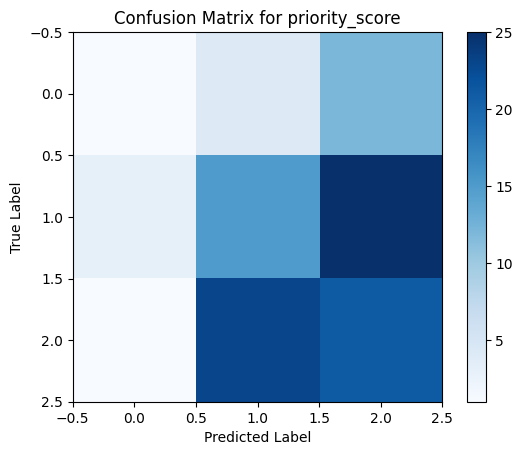

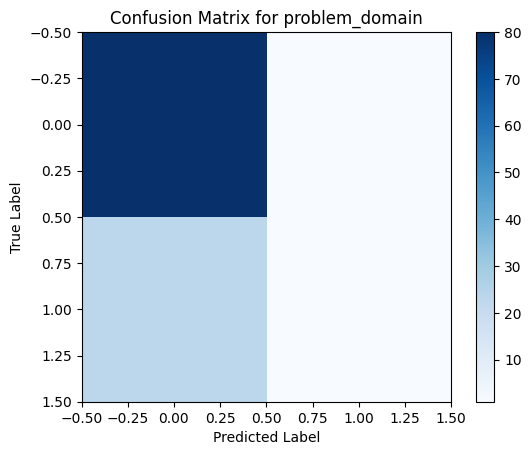

In [15]:
# Calculate and print classification report for priority_score
report1 = classification_report(y_test1, y_pred1)
print("Classification Report for priority_score:")
print(report1)

# Calculate and print classification report for problem_domain
report2 = classification_report(y_test2, y_pred2)
print("Classification Report for problem_domain:")
print(report2)

# Calculate and plot confusion matrix for priority_score
cm1 = confusion_matrix(y_test1, y_pred1)
plt.imshow(cm1, cmap='Blues')
plt.title("Confusion Matrix for priority_score")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate and plot confusion matrix for problem_domain
cm2 = confusion_matrix(y_test2, y_pred2)
plt.imshow(cm2, cmap='Blues')
plt.title("Confusion Matrix for problem_domain")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [11]:
# Define the parameter grid for Grid Search for priority_score
param_grid1 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Define the parameter grid for Grid Search for problem_domain
param_grid2 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 3, 5]
}

# Initialize the Random Forest classifiers
rf_classifier1 = RandomForestClassifier(random_state=50)
rf_classifier2 = RandomForestClassifier(random_state=50)

# Perform Grid Search to find the best hyperparameters for priority_score
grid_search1 = GridSearchCV(estimator=rf_classifier1, param_grid=param_grid1, cv=5)
grid_search1.fit(X_train, y_train1)

# Perform Grid Search to find the best hyperparameters for problem_domain
grid_search2 = GridSearchCV(estimator=rf_classifier2, param_grid=param_grid2, cv=5)
grid_search2.fit(X_train, y_train2)

# Get the best classifiers with the optimal hyperparameters
best_classifier1 = grid_search1.best_estimator_
best_classifier2 = grid_search2.best_estimator_

# Evaluate the best classifiers on the test sets for priority_score
y_pred1 = best_classifier1.predict(X_test)
classification_rep1 = classification_report(y_test1, y_pred1)

# Evaluate the best classifiers on the test sets for problem_domain
y_pred2 = best_classifier2.predict(X_test)
classification_rep2 = classification_report(y_test2, y_pred2)

print("Best Hyperparameters for priority_score:", grid_search1.best_params_)
print("Classification Report for priority_score:")
print(classification_rep1)

print("Best Hyperparameters for problem_domain:", grid_search2.best_params_)
print("Classification Report for problem_domain:")
print(classification_rep2)

Best Hyperparameters for priority_score: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Classification Report for priority_score:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        17
           2       0.41      0.35      0.38        43
           3       0.46      0.60      0.52        45

    accuracy                           0.40       105
   macro avg       0.29      0.32      0.30       105
weighted avg       0.36      0.40      0.38       105

Best Hyperparameters for problem_domain: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report for problem_domain:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        81
           1       0.00      0.00      0.00        24

    accuracy                           0.77       105
   macro avg       0.39      0.50      0.44       105
weighted avg       0.60      0.77      0.67       105


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
